In [47]:
import pandas as pd
import warnings

warnings.filterwarnings("ignore")
pd.set_option("mode.copy_on_write", True)

data_2 = "https://github.com/MIDS-at-Duke/opioid-2023-group-8-final-opioid/raw/data_merging/20_Intermediate_Files/Florida_Merged.csv"

fl_and_control_death = pd.read_csv(data_2)

In [48]:
fl_and_control_death["Deaths"].sum()

60847.0

In [49]:
# Dropping rows where there is any NA value
fl_and_control_death_cleaned = fl_and_control_death.dropna()

In [50]:
fl_and_control_death_cleaned.sample(5)

,Year,State Code,County,County Code,Population,Deaths,Dosage
6198,2009,FL,"Pasco County, FL",12101,462607.0,166.0,5.613402e+08
6714,2011,TN,"Madison County, TN",47113,98095.0,9.0,4.531618e+07
5687,2007,KY,"Larue County, KY",21123,14008.0,2.0,3.555951e+06
7233,2012,KY,"Butler County, KY",21031,12745.0,3.0,9.939460e+06
6041,2008,KY,"Hickman County, KY",21105,4957.0,1.0,9.339852e+05


## Death-per-capita for FL and Control States

In [51]:
# Calculating death_per_capita
fl_and_control_death_cleaned["Death_per_capita"] = (
    fl_and_control_death_cleaned["Deaths"] / fl_and_control_death_cleaned["Population"]
)

## Sort out for FL and Control States Separately

In [52]:
# subset the data for only FL
fl_treatment_state = fl_and_control_death_cleaned[
    fl_and_control_death_cleaned["State Code"] == "FL"
]
# subset the data for only the control states
controls = ["KY", "OR", "TN"]
control_states = fl_and_control_death_cleaned[
    fl_and_control_death_cleaned["State Code"].isin(controls)
]

In [53]:
fl_treatment_state.sample(5)

,Year,State Code,County,County Code,Population,Deaths,Dosage,Death_per_capita
6813,2011,FL,"Bradford County, FL",12007,28430.0,4.0,2.127173e+07,0.000141
5279,2006,FL,"Levy County, FL",12075,39447.0,6.0,1.865965e+07,0.000152
5567,2007,FL,"Okaloosa County, FL",12091,182677.0,29.0,5.198842e+07,0.000159
6211,2009,FL,"Volusia County, FL",12127,494688.0,106.0,3.701440e+08,0.000214
6824,2011,FL,"Escambia County, FL",12033,299478.0,29.0,1.462137e+08,0.000097


In [54]:
control_states.sample(5)

,Year,State Code,County,County Code,Population,Deaths,Dosage,Death_per_capita
6707,2011,OR,"Lake County, OR",41037,7908.0,1.0,4.355986e+06,0.000126
6957,2011,KY,"Livingston County, KY",21139,9504.0,3.0,6.414857e+06,0.000316
7856,2014,KY,"Pulaski County, KY",21199,63894.0,9.0,3.281740e+07,0.000141
5366,2006,KY,"Lincoln County, KY",21137,24838.0,4.0,4.818998e+06,0.000161
5292,2006,KY,"Whitley County, KY",21235,36149.0,11.0,4.660111e+07,0.000304


## Plot Diff-in-Diff

In [55]:
sub_fl_treatment_state = fl_treatment_state[
    (fl_treatment_state["Year"] >= 2006) & (fl_treatment_state["Year"] <= 2013)
]

sub_control_states = control_states[
    (control_states["Year"] >= 2006) & (control_states["Year"] <= 2013)
]

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn.objects as so
from matplotlib.lines import Line2D

# specify the years needed before the policy change
year = [2006, 2007, 2008, 2009]
# create new dataframe with only data from those years
pre_FL_death = sub_fl_treatment_state.loc[sub_fl_treatment_state["Year"].isin(year)]
post_FL_death = sub_fl_treatment_state.loc[~sub_fl_treatment_state["Year"].isin(year)]

pre_crtl_death = sub_control_states.loc[sub_control_states["Year"].isin(year)]
post_crtl_death = sub_control_states.loc[~sub_control_states["Year"].isin(year)]

In [57]:
import numpy as np
import statsmodels.formula.api as smf


def get_reg_fit(data, color, yvar, xvar, legend, alpha=0.05):
    years = list(np.arange(2006, 2013, 1))

    # Grid for predicted values
    x = data.loc[pd.notnull(data[yvar]), xvar]
    xmin = x.min()
    xmax = x.max()
    step = (xmax - xmin) / 100
    grid = np.arange(xmin, xmax + step, step)
    predictions = pd.DataFrame({xvar: grid})

    # Fit model, get predictions
    model = smf.ols(f"{yvar} ~ {xvar}", data=data).fit()
    model_predict = model.get_prediction(predictions[xvar])
    predictions[yvar] = model_predict.summary_frame()["mean"]
    predictions[["ci_low", "ci_high"]] = model_predict.conf_int(alpha=alpha)

    # Build chart
    predictions["Treat"] = f"{legend}"

    # Plotting regression line
    plt.plot(predictions[xvar], predictions[yvar], color=color, label=legend)

    # Plotting confidence interval
    plt.fill_between(
        predictions[xvar],
        predictions["ci_low"],
        predictions["ci_high"],
        color=color,
        alpha=0.3,
        label=f"{legend} CI",
    )

    plt.xlabel(xvar)
    plt.ylabel("Death per Capita")

    return predictions

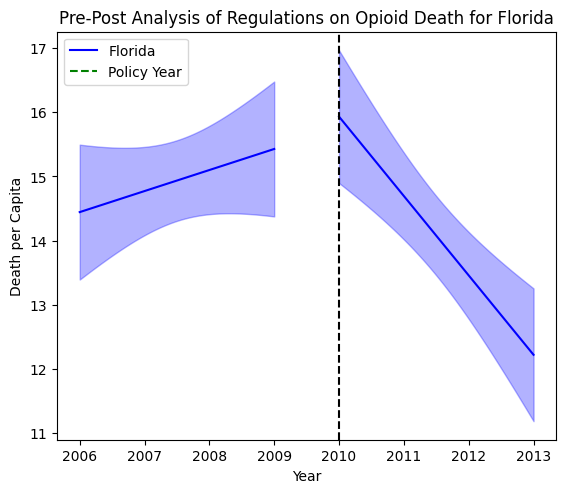

In [58]:
# Create subplots
fig, ax = plt.subplots()

# Scale up the 'Death_per_capita' values by multiplying by 100000
pre_FL_death["Death_per_capita_scaled"] = pre_FL_death["Death_per_capita"] * 100000
post_FL_death["Death_per_capita_scaled"] = post_FL_death["Death_per_capita"] * 100000

# Plot pre_FL_plot
pre_FL_plot = get_reg_fit(
    pre_FL_death, "blue", "Death_per_capita_scaled", "Year", "Florida", alpha=0.05
)

# Plot post_FL_plot
post_FL_plot = get_reg_fit(
    post_FL_death, "blue", "Death_per_capita_scaled", "Year", "Florida", alpha=0.05
)

# Plotting a vertical line for the policy year
ax.axvline(x=2010, color="black", linestyle="--", label="Policy Year")

plt.title("Pre-Post Analysis of Regulations on Opioid Death for Florida")

plt.legend(
    handles=[
        Line2D([0], [0], color="blue", label="Florida"),
        Line2D([0], [0], color="green", linestyle="--", label="Policy Year"),
    ],
    loc="upper left",
)

# Show the plot
plt.subplots_adjust(left=0.17, right=0.95, top=0.95, bottom=0.1)
plt.savefig("PrePostDeathFlorida.png", format="png")
plt.show()

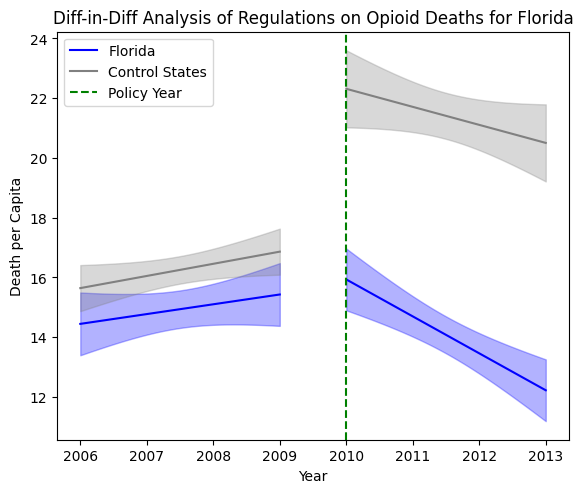

In [59]:
# Plot all data on the same chart
fig, ax = plt.subplots()

# Plot pre_FL_plot
pre_FL_plot = get_reg_fit(
    pre_FL_death, "blue", "Death_per_capita_scaled", "Year", "Florida", alpha=0.05
)

# Plot post_FL_plot
post_FL_plot = get_reg_fit(
    post_FL_death, "blue", "Death_per_capita_scaled", "Year", "Florida", alpha=0.05
)


# Ensure the same scaling is applied to the control states dataframes
pre_crtl_death["Death_per_capita_scaled"] = pre_crtl_death["Death_per_capita"] * 100000
post_crtl_death["Death_per_capita_scaled"] = (
    post_crtl_death["Death_per_capita"] * 100000
)

# Plot pre_crtl_plot
pre_crtl_plot = get_reg_fit(
    pre_crtl_death,
    "grey",
    "Death_per_capita_scaled",
    "Year",
    "Control States",
    alpha=0.05,
)

# Plot post_crtl_plot
post_crtl_plot = get_reg_fit(
    post_crtl_death,
    "grey",
    "Death_per_capita_scaled",
    "Year",
    "Control States",
    alpha=0.05,
)

# Plotting a vertical line for the policy year
ax.axvline(x=2010, color="green", linestyle="--", label="Policy Year")

# Set chart title
plt.title("Diff-in-Diff Analysis of Regulations on Opioid Deaths for Florida")

# Display the legend with more specific labels
plt.legend(
    handles=[
        Line2D([0], [0], color="blue", label="Florida"),
        Line2D([0], [0], color="grey", label="Control States"),
        Line2D([0], [0], color="green", linestyle="--", label="Policy Year"),
    ],
    loc="upper left",
)

# Show the plot
plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.1)
plt.savefig("DiffDeathFlorida.png", format="png")
plt.show()